# Atelier PyTorch : les bases pour être autonome 
#### 3 novembre 2022 de 9h à 17h à l'OMP (salle Coriolis)

L'objectif de cet atelier est de comprendre le fonctionnement de la bibliothèque PyTorch et de s'en approprier les bases pour être autonome.

Lien vers Google Colab : https://colab.research.google.com/drive/1pp_FLL5FcWdaPo3t94JQh961mqS7yvOI?usp=sharing

# Partie 1
## Manipuler les objets basiques de PyTorch : tenseurs, paramètres, modèles... 

Tout au long de l'atelier, nous travaillerons avec un modèle classique dans la litérature du machine learning : AlexNet [1], un réseau de neurones profond à convolutions pour la classification d'images naturelles (voir exemples d'images des données ImageNet ci-dessous).

Dans cette première partie, nous allons : 
 * Définir un **modèle PyTorch** de AlexNet,
 * Explorer son architecture et en particulier, faire la différence entre les **tenseurs** et les **paramètres** qui le constituent,
 * Apprendre les opérations basiques sur les tenseurs,
 * Charger dans le modèle des paramètres **pré-entrainés**,
 * **Visualiser** les noyaux de convolution,
 * Définir notre **propre** couche de convolution.
 
[1] Krizhevsky, Alex et al. “ImageNet classification with deep convolutional neural networks.” Communications of the ACM 60 (2012): 84 - 90.
 
<img src="image_net.png" width=500 height=200 />

<center>Exemples d'images de ImageNet</center>

### Définir un modèle

In [5]:
import torch
import torch.nn as nn 

In [6]:
class AlexNet(nn.Module):
    """
    AlexNet model architecture from the <https://arxiv.org/abs/1404.5997>`_ paper.
    Credits to https://github.com/Lornatang/AlexNet-PyTorch 
    """
    def __init__(self, num_classes=10, dropout_rate=0):
        # Notre modèle, comme tous les réseaux de neurones dans PyTorch,
        # hérite de la classe générique nn.Module.
        super().__init__()
        
        # A l'initialisation, on définit les couches du modèle, les fonctions
        # d'activation, etc. 

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
        # On définit aussi les distributions de probabilité selon lesquelles
        # les paramètres du modèle vont être initialisés.
        
        # Première option 
        for m in self.modules():
            # Les paramètres sont initialisés différemment 
            # selon le type de couche.
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
        
                
        # Seconde option pour initialiser les poids :
        #self.apply(self.init_weights)
        
                
    @staticmethod            
    def init_weights(m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)
                
    def extract_features(self, inputs):
        """ Returns output of the final convolution layer """
        x = self.features(inputs)
        return x

    def forward(self, inputs):
        x = self.features(inputs)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [7]:
model = AlexNet()
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
   

model.named_parameters() renvoie un générateur de tuples contenant le nom et la valeur des paramètres d'une instance de nn.Module

In [8]:
[(x[0], x[1].shape) for x in model.named_parameters()]

[('features.0.weight', torch.Size([64, 3, 11, 11])),
 ('features.0.bias', torch.Size([64])),
 ('features.3.weight', torch.Size([192, 64, 5, 5])),
 ('features.3.bias', torch.Size([192])),
 ('features.6.weight', torch.Size([384, 192, 3, 3])),
 ('features.6.bias', torch.Size([384])),
 ('features.8.weight', torch.Size([256, 384, 3, 3])),
 ('features.8.bias', torch.Size([256])),
 ('features.10.weight', torch.Size([256, 256, 3, 3])),
 ('features.10.bias', torch.Size([256])),
 ('classifier.1.weight', torch.Size([4096, 9216])),
 ('classifier.1.bias', torch.Size([4096])),
 ('classifier.4.weight', torch.Size([4096, 4096])),
 ('classifier.4.bias', torch.Size([4096])),
 ('classifier.6.weight', torch.Size([10, 4096])),
 ('classifier.6.bias', torch.Size([10]))]

model.parameters() renvoie un générateur contenant uniquement la valeur des paramètres d'une instance de nn.Module

In [9]:
[param.shape for param in model.parameters()]

[torch.Size([64, 3, 11, 11]),
 torch.Size([64]),
 torch.Size([192, 64, 5, 5]),
 torch.Size([192]),
 torch.Size([384, 192, 3, 3]),
 torch.Size([384]),
 torch.Size([256, 384, 3, 3]),
 torch.Size([256]),
 torch.Size([256, 256, 3, 3]),
 torch.Size([256]),
 torch.Size([4096, 9216]),
 torch.Size([4096]),
 torch.Size([4096, 4096]),
 torch.Size([4096]),
 torch.Size([10, 4096]),
 torch.Size([10])]

In [10]:
def n_params(model):
    n = 0
    for param in model.parameters():
        n += param.shape.numel()
    return n

print("{:.2e}".format(n_params(model)))

5.70e+07


In [11]:
type(model.features[0].weight)

torch.nn.parameter.Parameter

In [12]:
model.features[0].weight.requires_grad

True

### Le  tenseur, l'élément de base

In [13]:
kernels = model.features[0].weight.data
type(kernels)

torch.Tensor

Un tenseur (torch.Tensor) est l'équivalent du array de numpy. On peut souvent y appliquer les mêmes méthodes telle que .shape

In [14]:
kernels.shape

torch.Size([64, 3, 11, 11])

In [15]:
reshaped_kernels = kernels.view(-1, 11, 11)
reshaped_kernels.shape

torch.Size([192, 11, 11])

.view est l'équivalent de .reshape

In [16]:
avg_kernels_over_rgb = torch.mean(kernels, dim=1)
avg_kernels_over_rgb.shape

torch.Size([64, 11, 11])

On peut également facilement ajouter ou retirer une dimension comme suit :

In [17]:
print(kernels.shape)
kernels = kernels.unsqueeze(0)
print(kernels.shape)
kernels = kernels.squeeze(0)
print(kernels.shape)
kernels = kernels.unsqueeze(1)
print(kernels.shape)
kernels = kernels.squeeze(1)
print(kernels.shape)

torch.Size([64, 3, 11, 11])
torch.Size([1, 64, 3, 11, 11])
torch.Size([64, 3, 11, 11])
torch.Size([64, 1, 3, 11, 11])
torch.Size([64, 3, 11, 11])


On peut également moyenner ou sommer de la même manière qu'avec numpy.

#### Fonctions d'activation

In [18]:
type(model.features[4])

torch.nn.modules.activation.ReLU

In [19]:
model.features[4].inplace

True

## Charger des paramètres pré-entrainés

In [20]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model = model.to(device) # On charge le modèle sur GPU si elle est disponible
pretrained_weights = torch.load('../pretrained_alex_net.pth.tar', 
                                map_location=device) # on précise le "device" sur lequel est le modèle
model.load_state_dict(pretrained_weights['state_dict'])
del pretrained_weights # On supprime les poids de la mémoire du GPU

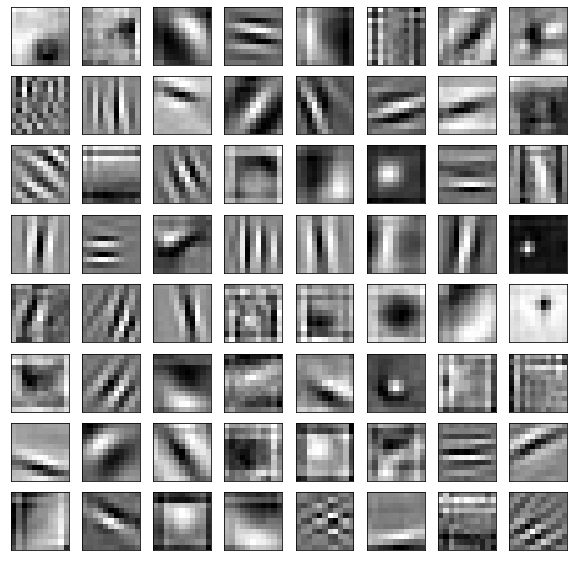

In [22]:
fig, ax = plt.subplots(8,8, figsize=(10,10))
k = 0
for i in range(8):
    for j in range(8):
        ax[i,j].imshow(model.features[0].weight.data[k,0,:,:].cpu(), cmap='gray')
        # model.features[0].weight.data is of size (64, 3, 11, 11)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        k += 1
plt.show()

## Définir sa propre couche de convolution 

Les noyaux de convolution ci-dessus ressemblent à des filtres de Gabor. On pourrait initialiser les noyaux de convolution comme des filtres de Gabor ou même optimiser des filtres de Gabor comme proposé dans [2] plutôt que des noyaux classiques.

Dans cette sous-partie, on va définir notre propre couche de filtre de Gabor. Précisémment, on va implémenter la partie réelle d'un filtre de Gabor qui est définie comme suit : 

$$g(x,y; \lambda, \psi, \sigma, \gamma, \theta) = exp(-\frac{x'^2 + \gamma^2 \cdot y'^2}{2\sigma^2}) \cdot cos(2\pi \frac{x'}{\lambda} + \psi)$$

$\lambda$, $\psi$, $\sigma$ et $\gamma$ seront des paramètres à optimiser. $\theta$ prendra plusieurs valeurs déterminées pour obtenir des filtres avec différentes orientations.

[2] Alekseev, Andrey, and Anatoly Bobe. "GaborNet: Gabor filters with learnable parameters in deep convolutional neural network." 2019 International Conference on Engineering and Telecommunication (EnT). IEEE, 2019.

En fait, on souhaiterait conserver les propriétés et fonctions d'une couche de convolution classique, mais en redéfinissant uniquement les poids de la convolution.

In [23]:
type(model.features[0])

torch.nn.modules.conv.Conv2d

On va donc écire une classe qui hérite de torch.nn.modules.conv.Conv2d

In [ ]:
# Compléter le code à chaque "..." 
class GaborFilters(torch.nn.modules.conv.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, bias=False,
                 padding_mode='zeros', device=None, dtype=None, n_thetas=5):
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.bias_ = bias
        self.padding_mode = padding_mode
        self.device = device
        self.dtype=dtype
        self.n_thetas = self.out_channels//16
        
        super().__init__(...)
        
        # A compléter 
        delattr(self, ...) 
        
        lambda_init_values = 1e-1+torch.rand(self.out_channels//self.n_thetas, 1, self.in_channels, 1, 1)*32
        psi_init_values = torch.rand(self.out_channels//self.n_thetas, 1, self.in_channels, 1, 1)*math.pi/2
        sigma_init_values = 1e-1+torch.rand(self.out_channels//self.n_thetas, 1, self.in_channels, 1, 1)*10
        gamma_init_values = torch.rand(self.out_channels//self.n_thetas, 1, self.in_channels, 1, 1)
        
        # A compléter
        self.lambda_ = ...
        self.psi = ...
        self.sigma = ...
        self.gamma = ...
        
        thetas = torch.linspace(0., 2*math.pi, self.n_thetas)
        
        # A compléter 
        self.register_buffer(...)
        
    @property
    def weight(self):
        # A compléter

    def gabor_filter(self):
        x = torch.arange(self.kernel_size[0], dtype=torch.float32) -  (self.kernel_size[0] - 1)/2
        # A compléter 
        x = x.view(...)
        y = torch.arange(self.kernel_size[0], dtype=torch.float32) -  (self.kernel_size[0] - 1)/2
        # A compléter
        y = y.view(...)
        
        # A compléter
        thetas = self.thetas.view(...)

        x_ =  x * torch.cos(thetas) + y * torch.sin(thetas)
        y_ = -x * torch.sin(thetas) + y * torch.cos(thetas)

        gb = torch.exp(-0.5 * ((x_ ** 2 + self.gamma**2 * y_ ** 2) / self.sigma ** 2)) \
                 * torch.cos(2.0 * math.pi  * x_ / self.lambda_ + self.psi)
        
        gb = gb.view(self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1])

        return gb

In [25]:
lambda_init_values = 1e-1+torch.rand(64//5, 1, 3, 1, 1)*32

In [27]:
lambda_init_values.shape
print(5*12)

60


In [ ]:
gb = GaborFilters(3, 64, 11)
kernels = gb.weight.cpu().detach()

fig, ax = plt.subplots(8,8, figsize=(10,10))
k = 0
for i in range(8):
    for j in range(8):
        ax[i,j].imshow(kernels[k,0,:,:], cmap='gray')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        k += 1
plt.show()

In [ ]:
x = torch.randn(1, 3, 50, 50)
out = gb(x)
loss = torch.linalg.norm(out)
print("Loss: ", loss)
print("Weight: ", gb.weight.mean())

optimizer = torch.optim.Adam(gb.parameters(), lr=0.1)
loss.backward()
optimizer.step()
print("Weight: ", gb.weight.mean())